In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install peft

In [ ]:
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import AutoTokenizer, BertModel
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
import nltk
import re
import string
from wordcloud import WordCloud
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')

# Initialize stop words, English words corpus
stop_words = set(stopwords.words('english'))
english_words = set(words.words())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
df = pd.read_csv ('/content/drive/MyDrive/FinalADR.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df=df.dropna()
df.head()

,text,searchTerm,disease,processed_text
0,Buy top levothyroxine online on our free compa...,Levothyroxine,Cancer,"['buy', 'top', 'free', 'comparison', 'site', '..."
1,@femmebostonian @Cherrell_Brown This has been ...,Levothyroxine,Cancer,"['super', 'help', 'switch', 'due', 'cost', 'ne..."
2,For a decade I was on Levothyroxine 137 mcg. I...,Levothyroxine,Cancer,"['decad', 'see', 'even', 'bit', 'bad', 'heart'..."
3,@yourAAH Hi could you tell me which of your UK...,Levothyroxine,Cancer,"['hi', 'could', 'tell', 'stock']"
4,And my levothyroxine,Levothyroxine,Cancer,[]


In [ ]:
stop_words = set(stopwords.words('english'))
english_words = set(words.words())

# Preprocess function
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)
df['Cleantext'] = df['text'].apply(preprocess)
df.head()

,text,searchTerm,disease,processed_text,Cleantext
0,Buy top levothyroxine online on our free compa...,Levothyroxine,Cancer,"['buy', 'top', 'free', 'comparison', 'site', '...",buy top levothyroxine online free comparison s...
1,@femmebostonian @Cherrell_Brown This has been ...,Levothyroxine,Cancer,"['super', 'help', 'switch', 'due', 'cost', 'ne...",femmebostonian cherrellbrown super helpful swi...
2,For a decade I was on Levothyroxine 137 mcg. I...,Levothyroxine,Cancer,"['decad', 'see', 'even', 'bit', 'bad', 'heart'...",decade levothyroxine mcg seeing changes sympto...
3,@yourAAH Hi could you tell me which of your UK...,Levothyroxine,Cancer,"['hi', 'could', 'tell', 'stock']",youraah hi could tell uk pharmacies stock mcg ...
4,And my levothyroxine,Levothyroxine,Cancer,[],levothyroxine


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['label']=encoder.fit_transform(df['disease'])


In [ ]:
X=df.Cleantext
Y=df.label
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.33, random_state=42)

# Further split temp into test and validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.225, random_state=42)

In [ ]:
X_train = X_train.tolist()
y_train = y_train.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()
y_val=y_val.tolist()
X_val=X_val.tolist()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=170)
valid_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=170)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=170)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
# Dataloader class
class DATALOADER(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = DATALOADER(train_encodings, y_train)
valid_dataset = DATALOADER(valid_encodings, y_val)
test_dataset = DATALOADER(test_encodings, y_test)

In [ ]:
# Function to create and apply LoRA configuration
def apply_lora(model, r, alpha, dropout):
    config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
        target_modules=["query", "value"],
    )
    lora_model = get_peft_model(model, config)
    return lora_model

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
    }

# Train model with this hyper parameters
Best Hyperparameters: {'alpha': 32, 'batch_size': 16, 'dropout': 0.2, 'epochs': 5, 'learning_rate': 0.001, 'r': 8}

In [ ]:
def apply_best_lora(model):
    config = LoraConfig(
        task_type=TaskType.SEQ_CLS,  # Sequence Classification task
        r=8,                        # Rank for the low-rank matrices
        lora_alpha=32,              # Scaling factor for LoRA
        lora_dropout=0.2,           # Dropout rate for LoRA
        target_modules=["query", "value"],  # Target modules to apply LoRA
    )
    lora_model = get_peft_model(model, config)
    return lora_model

# Compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
    }

# Load the base model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

# Apply LoRA with best parameters
lora_model = apply_best_lora(model)

# Define training arguments with best hyperparameters
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,                # Number of training epochs
    per_device_train_batch_size=16,    # Training batch size
    per_device_eval_batch_size=16,     # Evaluation batch size
    warmup_steps=500,                 # Number of warmup steps
    weight_decay=0.01,                # Weight decay
    logging_dir='./logs',             # Directory for logging
    load_best_model_at_end=True,      # Load the best model at the end
    evaluation_strategy="steps",      # Evaluate during training
    logging_steps=400,                # Number of steps between logging
    save_steps=400,                   # Number of steps between saves
    learning_rate=0.001,              # Learning rate
)

# Create Trainer instance
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
400,0.527900,0.115762,0.972696
800,0.100500,0.146317,0.959044
1200,0.047000,0.151140,0.969283
1600,0.031900,0.134552,0.976109


TrainOutput(global_step=1650, training_loss=0.1734456560828469, metrics={'train_runtime': 391.2734, 'train_samples_per_second': 67.395, 'train_steps_per_second': 4.217, 'total_flos': 1359839478996000.0, 'train_loss': 0.1734456560828469, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.1157621443271637,
 'eval_accuracy': 0.9726962457337884,
 'eval_runtime': 1.7666,
 'eval_samples_per_second': 165.854,
 'eval_steps_per_second': 10.755,
 'epoch': 10.0}

In [ ]:
eval_results =trainer.evaluate(test_dataset)

# Predict on the evaluation dataset to get logits
predictions = trainer.predict(test_dataset)

In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.12712232768535614,
 'eval_accuracy': 0.9731876861966237,
 'eval_runtime': 6.4393,
 'eval_samples_per_second': 156.383,
 'eval_steps_per_second': 9.784,
 'epoch': 10.0}

In [ ]:
import numpy as np

# Extract true labels
true_labels = predictions.label_ids

# Extract predicted labels (argmax over logits)
preds = np.argmax(predictions.predictions, axis=1)


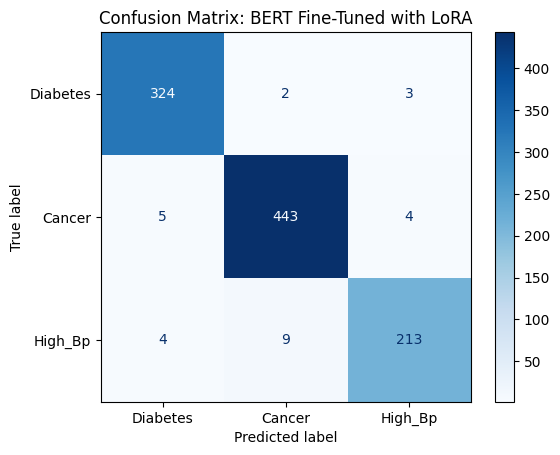

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = ['Diabetes', 'Cancer', 'High_Bp']

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix: BERT Fine-Tuned with LoRA')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming true_labels and preds are already defined
print(classification_report(true_labels, preds, target_names=labels))


              precision    recall  f1-score   support

    Diabetes       0.97      0.98      0.98       329
      Cancer       0.98      0.98      0.98       452
     High_Bp       0.97      0.94      0.96       226

    accuracy                           0.97      1007
   macro avg       0.97      0.97      0.97      1007
weighted avg       0.97      0.97      0.97      1007

